### 임베딩 계층 테스트

### RNN 계층 구현

In [ ]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid


class MyRNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = t #np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next #dh_next * (1 - h_next ** 2)
        
        db = np.sum(dt, axis=0)
        print('db=', db)
        dWh = np.dot(h_prev.T, dt)
        print('dWh=', dWh)
        dh_prev = np.dot(dt, Wh.T)
        print('dh_prev=', dh_prev)
        dWx = np.dot(x.T, dt)
        print('dWx=' , dWx)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### 케라스를 이용한 RNN 모델 구현

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

In [3]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [4]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [5]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
print(x_train_all[0])    

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [6]:
word_to_index = imdb.get_word_index()
word_to_index['movie']

17

In [7]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [8]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [9]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [10]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [11]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [12]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [13]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [14]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [15]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [16]:
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [17]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))  # (None,32)(32,32)+(None,100)(100,32)+(32,) => (None,32)
model.add(Dense(1, activation='sigmoid'))         # (None, 32)(32, 1)+(1,)  => (None, 1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 0.7069 - accuracy: 0.5005 - val_loss: 0.7021 - val_accuracy: 0.4904
Epoch 2/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6964 - accuracy: 0.5169 - val_loss: 0.6966 - val_accuracy: 0.5096
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6907 - accuracy: 0.5347 - val_loss: 0.6886 - val_accuracy: 0.5336
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6790 - accuracy: 0.5677 - val_loss: 0.6699 - val_accuracy: 0.5948
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6668 - accuracy: 0.5981 - val_loss: 0.7146 - val_accuracy: 0.5164
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6455 - accuracy: 0.6321 - val_loss: 0.6460 - val_accuracy: 0.6280
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6292 - accuracy: 0.6497 - val_loss: 0.6114 - val_accuracy: 0.6728
Epoch 

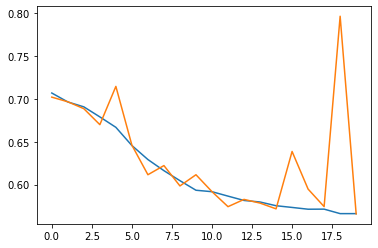

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

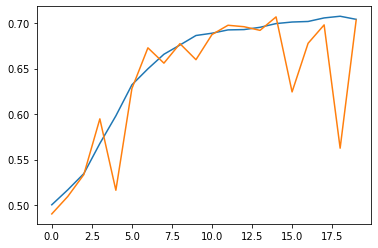

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [21]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.7031999826431274


In [22]:
from tensorflow.keras.layers import Embedding

In [23]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [24]:
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [25]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 328       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.5082 - accuracy: 0.7516 - val_loss: 0.4545 - val_accuracy: 0.7990
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3948 - accuracy: 0.8333 - val_loss: 0.4191 - val_accuracy: 0.8128
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3512 - accuracy: 0.8556 - val_loss: 0.4125 - val_accuracy: 0.8278
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3143 - accuracy: 0.8724 - val_loss: 0.4066 - val_accuracy: 0.8318
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2908 - accuracy: 0.8853 - val_loss: 0.4294 - val_accuracy: 0.8282
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2658 - accuracy: 0.8969 - val_loss: 0.4494 - val_accuracy: 0.8134
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2468 - accuracy: 0.9065 - val_loss: 0.4451 - val_accuracy: 0.8222
Epo

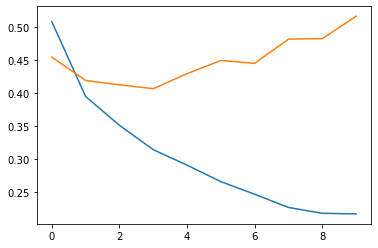

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

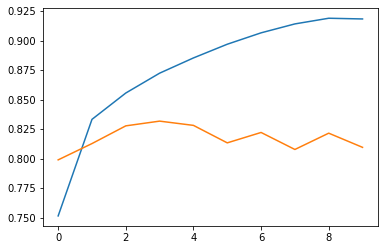

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [29]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8095999956130981


In [30]:
from tensorflow.keras.layers import LSTM

In [31]:
model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 lstm (LSTM)                 (None, 8)                 1312      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                         validation_data=(x_val_seq, y_val))

Epoch 1/10
395/625 [=================>............] - ETA: 2s - loss: 0.4991 - accuracy: 0.7590

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)